# Project:- Advanced Lane Detection

### Import Packages :

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Line Class Definition

In [2]:
#Line class to keep track of various features of Lane lines
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.all_x = None  
        # y values for detected line pixels
        self.all_y = None
        # counter to reset after 5 iterations if issues arise
        self.counter = 0
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

### Functions Definition :

In [3]:
def calibration():
   
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    

    img = cv2.imread(images[0])        
    img_size = (img.shape[1], img[0].shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx,dist
    
def undistort(image,mtx,dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

def binary_threshold(undist_img, s_thresh=(125, 255),r_thresh=(200,255),sx_thresh=(10,100),sx_kernel=3):
    
    # Taking only R channel from RGB
    r = undist_img[:,:,0]
    
    # Convert to HLS colorspace
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobelx - takes the derivate in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sx_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold R color channel
    r_binary = np.zeros_like(r)
    r_binary[(r >= r_thresh[0]) & (r <= r_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # If two of the three are activated, activate in the binary image
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (sxbinary == 1)) | ((sxbinary == 1) & (r_binary == 1))
                     | ((s_binary == 1) & (r_binary == 1))] = 1

    return combined_binary

def hawk_eye(image):
    image_size = (image.shape[1], image.shape[0])
    # source points
    src = np.float32([[690,450],[1110,image_size[1]],[175,image_size[1]],[595,450]])

    # destination points for perspective transform
    offset = 300
    dst = np.float32([[image_size[0]-offset, 0],[image_size[0]-offset, image_size[1]],
                      [offset, image_size[1]],[offset, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    hawk_view = cv2.warpPerspective(image, M, image_size)
    return hawk_view , M

def first_line(image,visualise = 0):
# Assumption: image is a warped binary image

    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image only
        if visualise != 0 :
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each left and right line
    try:
        left.current_fit = np.polyfit(lefty, leftx, 2)
        left.all_x = leftx
        left.all_y = lefty
        left.recent_fit.append(left.current_fit)
        left.recent_fit = left.recent_fit[-5:]
        left.best_fit = np.mean(left.recent_fit, axis = 0)
        left.detected = True
        left.counter = 0

        right.current_fit = np.polyfit(righty, rightx, 2)
        right.all_x = rightx
        right.all_y = righty
        right.recent_fit.append(right.current_fit)
        right.recent_fit = right.recent_fit[-5:]
        right.best_fit = np.mean(right.recent_fit, axis = 0)
        right.detected = True
        right.counter = 0
    except TypeError:
        left.detected = False
        left.counter = left.counter + 1
    except np.linalg.LinAlgError:
        left.detected = False
        left.counter = left.counter + 1
        
    if visualise != 0 :
            out_img[lefty,leftx] = [255, 0, 0]
            out_img[righty,rightx] = [0, 0, 255]
            return out_img


def draw_lines(image):
# Assumption: image is a warped binary image    
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_fit = left.current_fit
    right_fit = right.current_fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    try:
        left.current_fit = np.polyfit(lefty, leftx, 2)
        left.all_x = leftx
        left.all_y = lefty
        left.recent_fit.append(left.current_fit)
        left.recent_fit = left.recent_fit[-5:]
        left.best_fit = np.mean(left.recent_fit, axis = 0)
        left.detected = True
        left.counter = 0

        right.current_fit = np.polyfit(righty, rightx, 2)
        right.all_x = rightx
        right.all_y = righty
        right.recent_fit.append(right.current_fit)
        right.recent_fit = right.recent_fit[-5:]
        right.best_fit = np.mean(right.recent_fit, axis = 0)
        right.detected = True
        right.counter = 0
    except TypeError:
        left.detected = False
        left_fit = left_line.best_fit
        left.counter = left.counter + 1
    except np.linalg.LinAlgError:
        left.detected = False
        left_fit = left_line.best_fit
        left.counter = left.counter + 1

 
    
def curvature_calc(image):
    #Assumption :the lane is about 30 meters long and 3.7 meters wide
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = left.all_x 
    rightx = right.all_x 
    lefty = left.all_y 
    righty = right.all_y 
    try:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        left.radius_of_curvature = left_curverad
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        right.radius_of_curvature = right_curverad
        avg_curverad = round(np.mean([left_curverad, right_curverad]),0)
        output_text = "Radius of Curvature = {}(m)".format(avg_curverad)
    except TypeError:
        output_text = "NA"
    

    
    return output_text
    
def car_position(image):
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Calculating middle of the image
    mid_pos = image.shape[1] / 2
    car_pos = mid_pos * xm_per_pix
 
    leftx = left.all_x 
    rightx = right.all_x 
    lefty = left.all_y 
    righty = right.all_y 
    try:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculating middle of the lane
        val = image.shape[0] * ym_per_pix
        left_line_base = (left_fit_cr[0]*val**2) + (left_fit_cr[1]*val) + left_fit_cr[2]
        right_line_base = (right_fit_cr[0]*val**2) + (right_fit_cr[1]*val) + right_fit_cr[2]
        lane_mid = (left_line_base+right_line_base)/2

        # Calculate distance from center and list differently based on left or right
        dist_from_center = lane_mid - car_pos
        if dist_from_center >= 0:
            center_text = "{} meters left of center".format(round(dist_from_center,2))
        else:
            center_text = "{} meters right of center".format(round(-dist_from_center,2))

        # List car's position in relation to middle on the image and radius of curvature
    except TypeError:
            center_text = "{} meters left of center".format(0)
    return center_text


def visualisation(undist,image,perspective_M,curve_text,position_text):
    ## Final Road Visualisation
        # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])

    left_fit = left.current_fit
    right_fit = right.current_fit
    if(len(right_fit)!=3):
        right_fit=left_fit
    if(len(left_fit)!=3):
        left_fit=right_fit
    if left_fit is None or right_fit is None:
        return undist    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts_left]), (255,0,125))
    cv2.fillPoly(color_warp, np.int_([pts_right]), (125,0,255))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Invert the transform matrix to get normal view
    Minv = np.linalg.inv(perspective_M)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    cv2.putText(undist, curve_text, (10,100), cv2.FONT_HERSHEY_SIMPLEX , 1,(255,255,255),2)
    cv2.putText(undist, position_text, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

### Camera Calibration

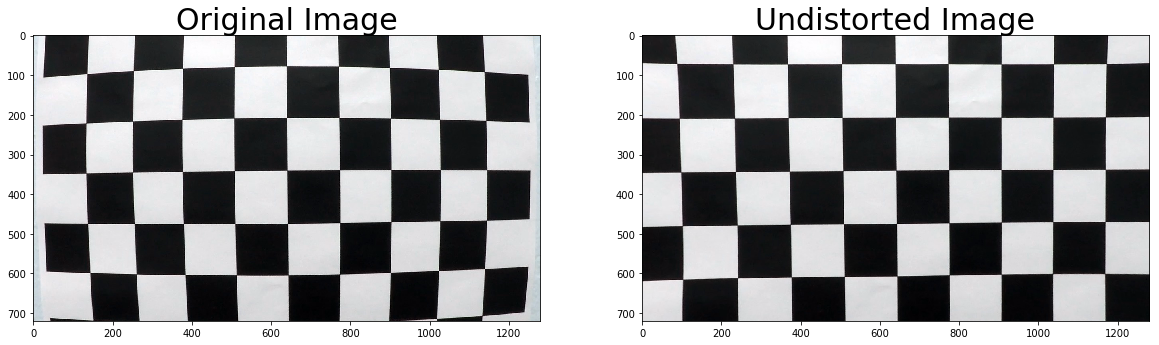

In [4]:
#Needs to be run only once for camera calibration
mtx,dist = calibration()
in_img = cv2.imread('camera_cal/calibration1.jpg')
out_img = undistort(in_img,mtx,dist)
cv2.imwrite('output_images/undistored_chess.jpg',out_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(in_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Undistorted Image', fontsize=30)

### Project Pipeline

In [5]:
def pipeline(image,mtx,dist):
    
    undist = undistort(image,mtx,dist)
    binary = binary_threshold(undist)
    hawk_view , M = hawk_eye(binary)
    if left.detected == False | right.detected == False:
        first_line(hawk_view)
    else:
        draw_lines(hawk_view)
    curve = curvature_calc(hawk_view)    
    pos = car_position(hawk_view)
    result = visualisation(undist,hawk_view,M,curve,pos)
    return result

### Process Visualisation 

##### 1. Undistorting the image

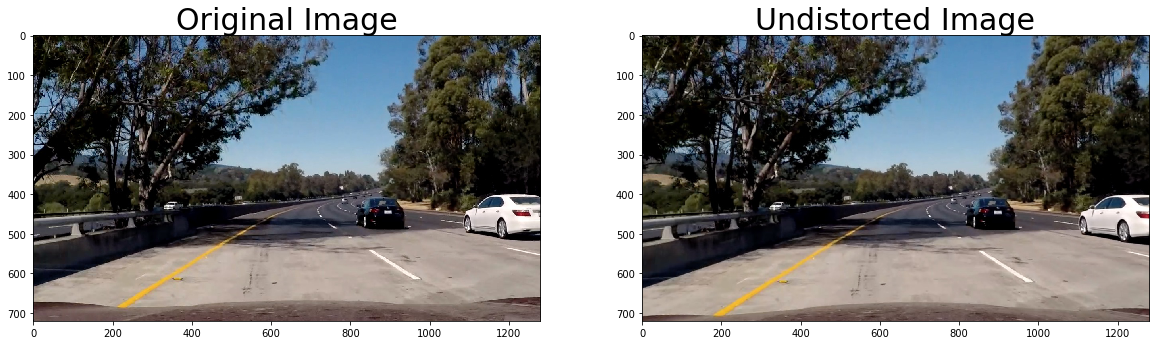

In [6]:
in_img = cv2.imread('test_images/test5.jpg')
out_img = undistort(in_img,mtx,dist)
undst = out_img
cv2.imwrite('output_images/undistorted.jpg',out_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

##### 2. Binary Color Thresholding

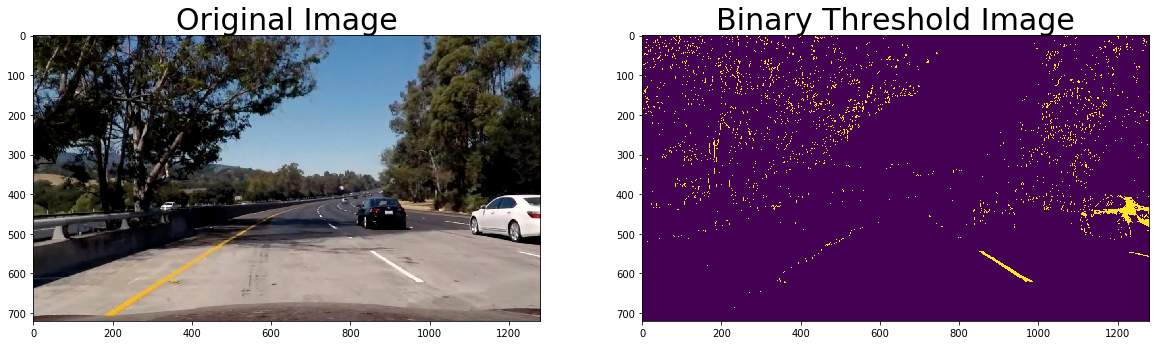

In [7]:
in_img = out_img
out_img = binary_threshold(in_img)
cv2.imwrite('output_images/binary.jpg',out_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Binary Threshold Image', fontsize=30)

##### 3. Perspective Transformation

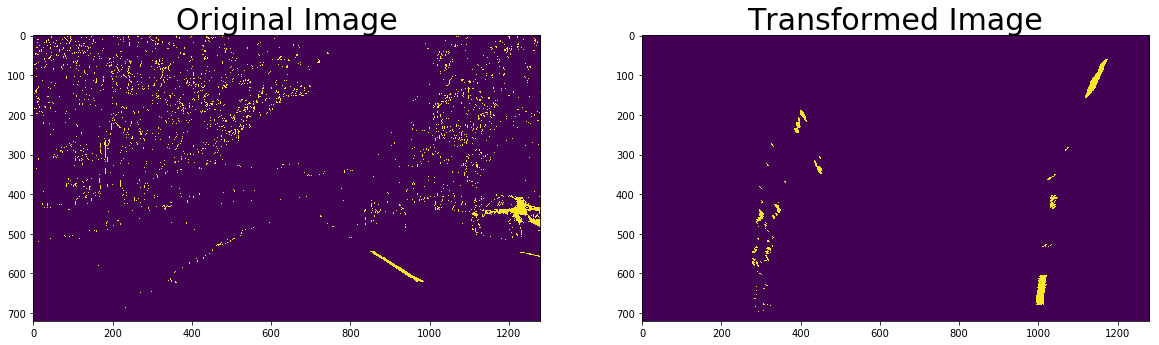

In [8]:
in_img = out_img
out_img,m = hawk_eye(in_img)
hawk_img = out_img
cv2.imwrite('output_images/transform.jpg',out_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(in_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Transformed Image', fontsize=30)

##### 4. Line Detection

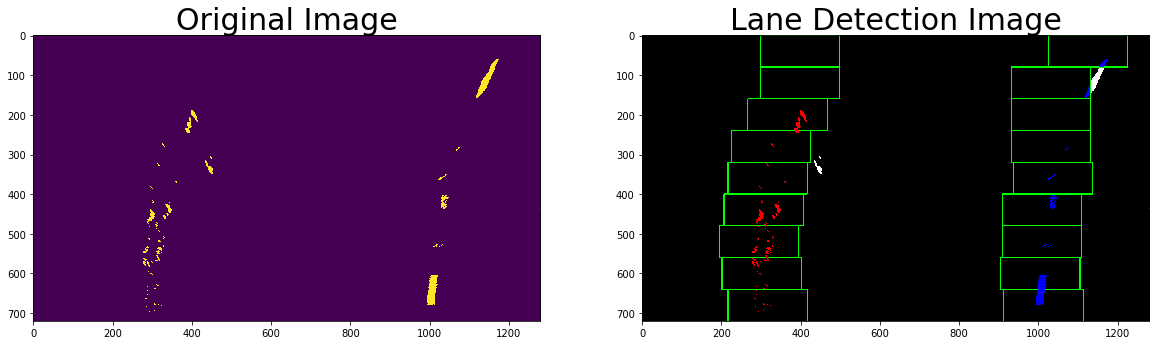

In [9]:
in_img = out_img
left = Line()
right = Line()
out_img = first_line(in_img,1)
cv2.imwrite('output_images/lane_line.jpg',out_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(in_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Lane Detection Image', fontsize=30)

##### 5. Final output Image

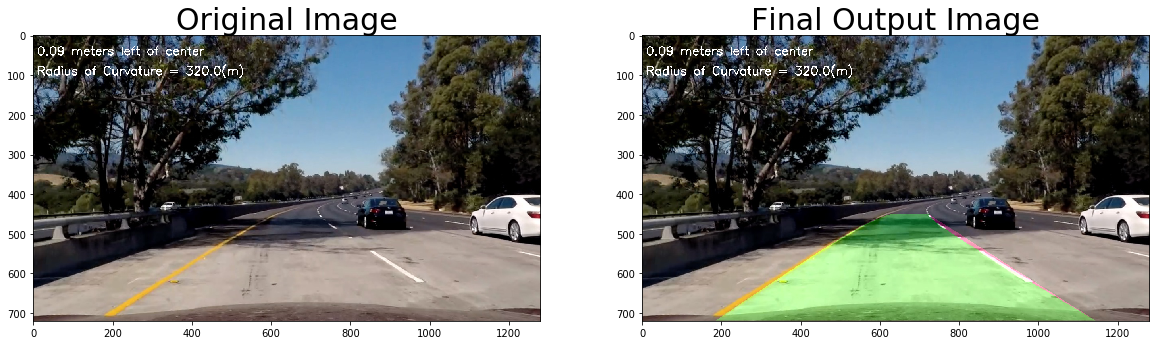

In [10]:
in_img = undst
c = curvature_calc(hawk_img)    
p = car_position(hawk_img)
out_img = visualisation(undst,hawk_img,m,c,p)
cv2.imwrite('output_images/final_output.jpg',out_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB))
ax2.set_title('Final Output Image', fontsize=30)

### Video Processing

In [11]:
# Line objects for tracking various features of left and right lane lines
left = Line()
right = Line()

def process_image(image):
    
    result = pipeline(image, mtx, dist)

    return result



# Convert to video
# vid_output is where the image will be saved to
vid_output = 'output_video.mp4'

# The file referenced in clip1 is the original video before anything has been done to it
clip1 = VideoFileClip('project_video.mp4')

# NOTE: this function expects color images

vid_clip = clip1.fl_image(process_image)
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [04:01<00:00,  5.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))